In [2]:
# STEP 0 — Setup Kaggle & Install dependencies
!pip install kaggle tqdm tensorflow matplotlib --quiet
from google.colab import files
import os
files.upload()
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)
!kaggle datasets download -d vanshikavmittal/fakeddit-dataset -p /content
!unzip -q /content/fakeddit-dataset.zip -d /content/fakeddit

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vanshikavmittal/fakeddit-dataset
License(s): unknown
  0% 0.00/72.8M [00:00<?, ?B/s]
100% 72.8M/72.8M [00:00<00:00, 1.68GB/s]


In [3]:
# STEP 1 — Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm
import glob
import random
import matplotlib.pyplot as plt

In [4]:
# STEP 2 — Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
# STEP 3 — Prepare Folders
base_dir = "/content/fakeddit_images"
os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(d, "real"), exist_ok=True)
    os.makedirs(os.path.join(d, "fake"), exist_ok=True)

In [30]:
# STEP 4 — Load TSV Files
train_df = pd.read_csv("/content/fakeddit/multimodal_only_samples/multimodal_train.tsv", sep="\t")
val_df   = pd.read_csv("/content/fakeddit/multimodal_only_samples/multimodal_validate.tsv", sep="\t")
test_df  = pd.read_csv("/content/fakeddit/multimodal_only_samples/multimodal_test_public.tsv", sep="\t")

train_df = train_df[train_df["hasImage"] == True].dropna(subset=["image_url"])
val_df   = val_df[val_df["hasImage"] == True].dropna(subset=["image_url"])
test_df  = test_df[test_df["hasImage"] == True].dropna(subset=["image_url"])

# Increase sample size for better performance
train_df = train_df.sample(5000, random_state=42)
val_df   = val_df.sample(1000, random_state=42)
test_df  = test_df.sample(1000, random_state=42)

In [31]:
# STEP 5 — Download images
def download_images(df, folder):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        label = "real" if row["2_way_label"] == 1 else "fake"
        url = row["image_url"]
        filename = os.path.join(folder, label, f"{row['id']}.jpg")
        if os.path.exists(filename):
            continue
        try:
            response = requests.get(url, timeout=8)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            img.save(filename)
        except:
            continue

download_images(train_df, train_dir)
download_images(val_df, val_dir)
download_images(test_df, test_dir)

 23%|██▎       | 1144/5000 [00:18<05:54, 10.87it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1000/1000 [01:37<00:00, 10.24it/s]


In [32]:
# STEP 6 — Remove corrupted images
def remove_corrupted_images(folder):
    count_removed = 0
    for filename in glob.glob(folder + '/**/*.jpg', recursive=True):
        try:
            img = Image.open(filename)
            img.verify()
        except:
            os.remove(filename)
            count_removed += 1
    print(f"Removed {count_removed} corrupted files.")
remove_corrupted_images(base_dir)

Removed 0 corrupted files.


In [33]:
# STEP 7 — Image Generators
img_size = (299, 299)  # updated size
batch_size = 16

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
).flow_from_directory(
    train_dir,
    target_size=img_size,  # updated size here
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=img_size,  # updated size here
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=img_size,  # updated size here
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 3474 images belonging to 2 classes.
Found 695 images belonging to 2 classes.
Found 725 images belonging to 2 classes.


In [34]:
def resnet_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    if stride != 1:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Input
inp = Input(shape=(299,299,3))  # updated input shape
x = Conv2D(32, 3, padding='same', strides=1)(inp)
x = BatchNormalization()(x)
x = ReLU()(x)

# 3 residual blocks → ResNet10-style
x = resnet_block(x, 32)
x = resnet_block(x, 64, stride=2)
x = resnet_block(x, 128, stride=2)

# Classification head
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
out = Dense(1, activation='sigmoid')(x)

# Compile model
resnet10_model = Model(inp, out)
resnet10_model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet10_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 299, 299,  │        896 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 299, 299,  │        128 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 299, 299,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 299, 299,  │      9,248 │ re_lu_28[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 299, 299,  │        128 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 299, 299,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 299, 299,  │      9,248 │ re_lu_29[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 299, 299,  │        128 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 299, 299,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_30 (ReLU)     │ (None, 299, 299,  │          0 │ add_12[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 150, 150,  │     18,496 │ re_lu_30[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_31 (ReLU)     │ (None, 150, 150,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 150, 150,  │     36,928 │ re_lu_31[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 150, 150,  │      2,112 │ re_lu_30[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        256 │ conv2d_40[0][0] 

 Total params: 326,017 (1.24 MB)

 Trainable params: 324,673 (1.24 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [46]:
# STEP 9 — High-Accuracy ResNet50 Fine-Tuning

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# ⚙️ Data Generators (use preprocess_input for ResNet)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.25,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

print("Classes:", train_gen.class_indices)

#  Build Base Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most layers first
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True  # fine-tune last 30 layers

#  Custom Top Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

#  Compile Model
optimizer = Adam(learning_rate=1e-5)  # smaller LR for fine-tuning
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#  Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-7, verbose=1)

#  Train Model (More epochs)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Save model
model.save("/content/fakenews_resnet50_highacc.h5")

print(" Model training complete. Saved as fakenews_resnet50_highacc.h5.")

Found 3474 images belonging to 2 classes.
Found 695 images belonging to 2 classes.
Classes: {'fake': 0, 'real': 1}
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 92s 653ms/step - accuracy: 0.4754 - loss: 0.8862 - val_accuracy: 0.6101 - val_loss: 0.6650 - learning_rate: 1.0000e-05
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 52s 478ms/step - accuracy: 0.5308 - loss: 0.7636 - val_accuracy: 0.6403 - val_loss: 0.6333 - learning_rate: 1.0000e-05
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 53s 484ms/step - accuracy: 0.5977 - loss: 0.6893 - val_accuracy: 0.6460 - val_loss: 0.6149 - learning_rate: 1.0000e-05
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 53s 482ms/step - accuracy: 0.6047 - loss: 0.6814 - val_accuracy: 0.6662 - val_loss: 0.6021 - learning_rate: 1.0000e-05
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 55s 500ms/step - accuracy: 0.6176 - loss: 0.6697 - val_accuracy: 0.6849 - val_loss: 0.5922 - learning_rate: 1.0000e-05
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 54s 492ms/step - accuracy: 0.6224 - loss: 0.6562 -

 Model training complete. Saved as fakenews_resnet50_highacc.h5.


In [48]:
# STEP 10 — Evaluate and Predict (Fixed)

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Rebuild test generator properly
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    classes=['fake', 'real']  # enforce label order consistency
)

# Evaluate
loss, acc = model.evaluate(test_gen)
print(f" Test Accuracy: {acc:.3f} | Test Loss: {loss:.3f}")

# Predict
y_true = test_gen.classes
y_pred = (model.predict(test_gen) > 0.5).astype(int).reshape(-1)
# Optional: check confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

Found 725 images belonging to 2 classes.
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.5915 - loss: 0.6870
 Test Accuracy: 0.680 | Test Loss: 0.603
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step
[[168 170]
 [ 62 325]]
              precision    recall  f1-score   support

        Fake       0.73      0.50      0.59       338
        Real       0.66      0.84      0.74       387

    accuracy                           0.68       725
   macro avg       0.69      0.67      0.66       725
weighted avg       0.69      0.68      0.67       725



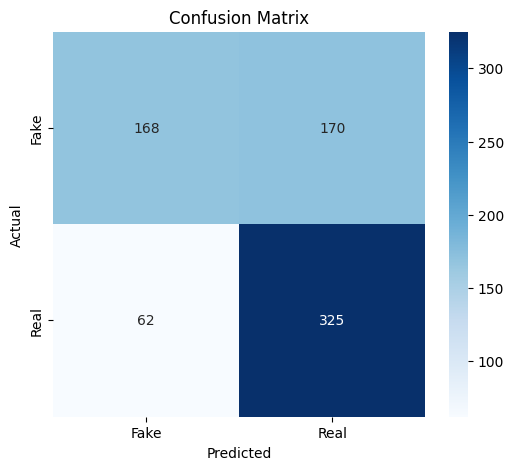

              precision    recall  f1-score   support

        Fake       0.73      0.50      0.59       338
        Real       0.66      0.84      0.74       387

    accuracy                           0.68       725
   macro avg       0.69      0.67      0.66       725
weighted avg       0.69      0.68      0.67       725



In [50]:
# STEP 11 — Confusion Matrix & Classification Report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report  # <-- add this

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Fake','Real']))


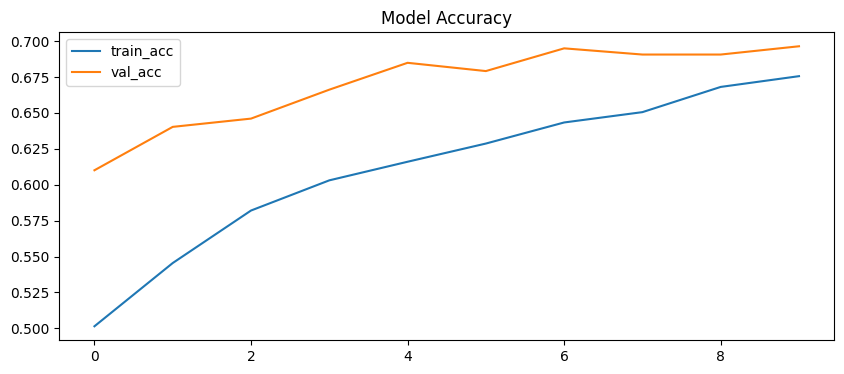

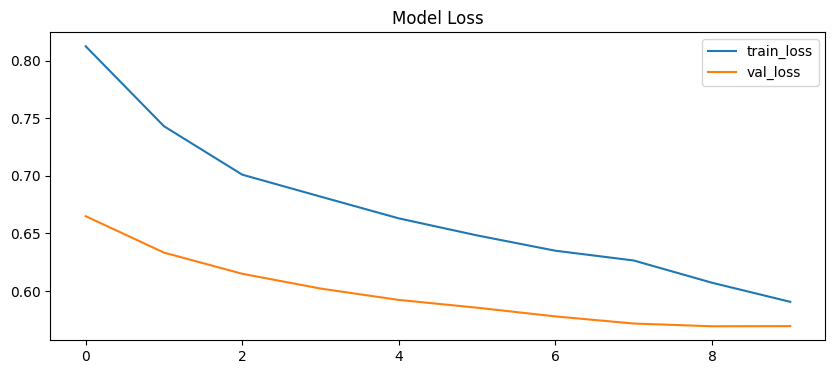

In [51]:
# STEP 12 — Plot Accuracy & Loss
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [52]:
!pip install gradio --quiet

In [53]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model = load_model("/content/fakenews_resnet50_model.h5")

In [54]:
from PIL import Image

def predict_fake_news(img):
    # Resize and normalize
    img = img.resize((224,224))
    img_array = np.array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array)[0][0]
    if pred > 0.5:
        label = "Real News"
    else:
        label = "Fake News"
    return f"{label} ({pred:.2f})"

In [55]:
import gradio as gr

ui = gr.Interface(
    fn=predict_fake_news,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Fake News Image Detector",
    description="Upload an image to check if the news is Real or Fake based on the image."
)

ui.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9b4c50983e0097f91f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
